In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import yaml
import wandb
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import os
import seaborn as sns


from model import CNNClassifier

### data processing

In [2]:
new_data = pd.read_csv('additional_data/myntradataset/styles.csv', on_bad_lines='skip')

label_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

label_names_dict = {i: label_names[i] for i in range(10)}

article_to_fmnist_label = {
    'Shirts': 0, 'Tops': 0, 'Tunics': 0,
    'Jeans': 1, 'Track Pants': 1, 'Trousers': 1, 'Leggings': 1, 'Lounge Pants': 1,
    'Sweatshirts': 2, 'Sweaters': 2, 'Kurtas': 2,
    'Dresses': 3, 'Nightdress': 3,
    'Jackets': 4, 'Blazers': 4, 'Rain Jacket': 4, 'Nehru Jackets': 4,
    'Sandals': 5, 'Sports Sandals': 5, 'Flip Flops': 5,
    'Tshirts': 6, 'Lounge Tshirts': 6,
    'Casual Shoes': 7, 'Sports Shoes': 7, 'Formal Shoes': 7,
    'Handbags': 8, 'Laptop Bag': 8, 'Duffel Bag': 8, 'Messenger Bag': 8, 'Trolley Bag': 8,
}

absent_images = [
    39403,
    39410,
    39401,
    39425
]

In [3]:
# Create a new column 'fashion_mnist_label' based on 'articleType' mapping
fashion_mnist_label = []
for row in np.array(new_data):
    article_type = row[4]
    name = row[-1]
    fashion_mnist_label.append(article_to_fmnist_label.get(article_type, np.nan))
    if article_type.lower().find('shoe') != -1:
        if ((name.lower().find('boot') != -1) or (name.lower().find('ankle') != -1)) and (name.lower().find('sport') == -1):
            fashion_mnist_label[-1] = 9

new_data['fashion_mnist_label'] = fashion_mnist_label


# Drop rows where 'fashion_mnist_label' is NaN, i.e., the article type did not match any FMNIST category
new_fmnist_data = new_data.dropna(subset=['fashion_mnist_label']).copy()
#new_fmnist_data = new_fmnist_data[['id', 'fashion_mnist_label']]
new_fmnist_data['label'] = new_fmnist_data['fashion_mnist_label'].map(label_names_dict)

# drop all rows where id is in absent_ids array, ids are inetegers
new_fmnist_data = new_fmnist_data[~new_fmnist_data['id'].isin(absent_images)]

### dataset and visualisations

In [4]:
def process_image(id, crop_width=60, crop_height=60, path='additional_data/images/'):
    image = cv.imread(path + str(id) + '.jpg')
    # fill in background to be black instead of white clr > (250, 250, 250)
    image[image > 252] = 0
    if image is None:
        print(f'Image {id} not found')
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate the cropping coordinates
    start_x = max(center_x - crop_width // 2, 0)
    start_y = max(center_y - crop_height // 2, 0)
    end_x = start_x + crop_width
    end_y = start_y + crop_height

    # Ensure the cropping dimensions do not exceed the image's bounds
    end_x = min(end_x, width)
    end_y = min(end_y, height)

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    # Resize the image to 28x28
    resized_image = cv.resize(cropped_image, (28, 28), interpolation=cv.INTER_AREA)

    # Convert the image to grayscale
    grayscale_image = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)

    pil_image = Image.fromarray(grayscale_image)
    
    return pil_image

class FashionMnist2(torch.utils.data.Dataset):
    def __init__(self, data, root_dir='additional_data/images/', transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_id = self.data.iloc[idx, 0]
        img = process_image(img_id, 55, 55, self.root_dir)
        
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            img = self.transform(img)
        return img, label


def plot_class_distribution(dataframe, column_name):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - dataframe: pd.DataFrame containing the data.
    - column_name: string, the name of the column with the class labels.
    """
    # Set the aesthetic style of the plots
    sns.set(style="darkgrid")

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column_name, data=dataframe, palette="viridis")
    
    # Add labels and title for clarity
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Classes in the Dataset')
    plt.xticks(rotation=45)  # Rotate labels to avoid overlap

    # Show the plot
    plt.show()


def read_img_display(id, crop_width=60, crop_height=60, path='additional_data/images/'):
    image = cv.imread(path + str(id) + '.jpg')
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate the cropping coordinates
    start_x = max(center_x - crop_width // 2, 0)
    start_y = max(center_y - crop_height // 2, 0)
    end_x = start_x + crop_width
    end_y = start_y + crop_height

    # Ensure the cropping dimensions do not exceed the image's bounds
    end_x = min(end_x, width)
    end_y = min(end_y, height)

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    # Resize the image to 28x28
    resized_image = cv.resize(cropped_image, (28, 28), interpolation=cv.INTER_AREA)

    # Convert the image to grayscale
    grayscale_image = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
    plt.imshow(grayscale_image, cmap='gray')

### exploration

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

new_dataset = FashionMnist2(new_fmnist_data[['id', 'fashion_mnist_label']], transform=transform)
new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

/var/folders/wl/tkx29dw96sbgly88cthpjgzc0000gn/T/ipykernel_10147/4099420422.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=dataframe, palette="viridis")


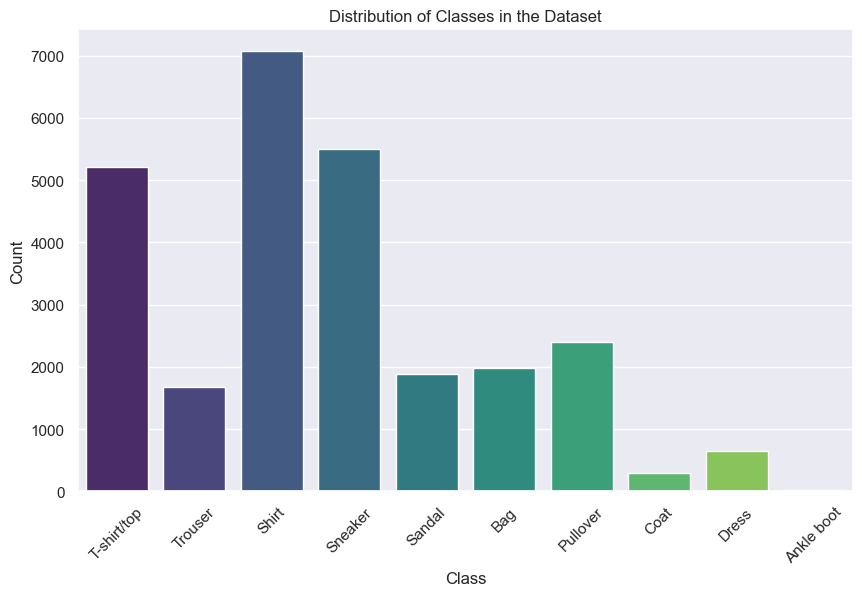

26680

In [20]:
plot_class_distribution(new_fmnist_data, 'label')
len(new_dataset)

In [6]:
with open('config_model4_1.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    config['log'] = 'stdout'
cls = CNNClassifier(config)
cls.load_checkpoint('weights/model4_1.pth')

In [7]:
cls.eval()
with torch.no_grad():
    for batch in new_loader:
        loss = cls.test_step(batch, 0)
cls.on_test_epoch_end()

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test accuracy: 0.13350824587706148
Test precision: 0.22687266411154866
Test recall: 0.21272998452728836
Test f1: 0.12287640367676131


### examples

  true label: Pullover, predicted label: Shirt


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


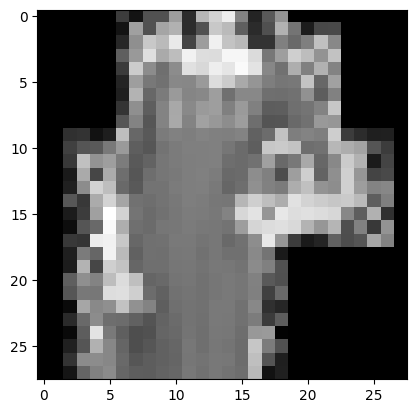

  true label: Shirt, predicted label: Shirt


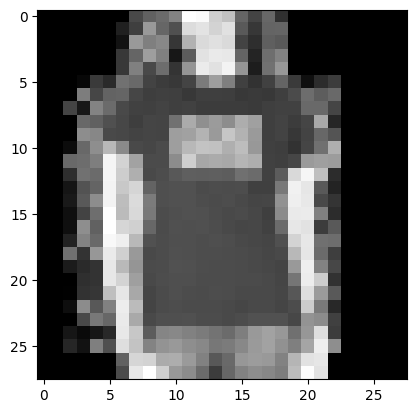

  true label: T-shirt/top, predicted label: Coat


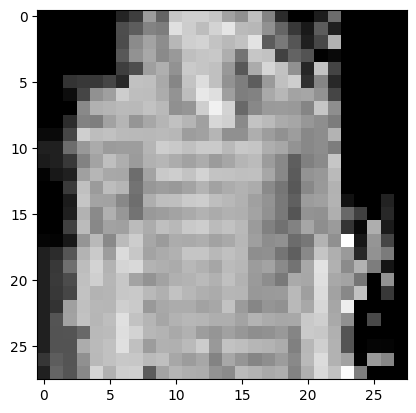

In [57]:
for i in range(3):
    img, lbl = new_dataset[np.random.randint(0, len(new_dataset))]
    plt.imshow(img[0], cmap='gray')
    pred = torch.argmax(nn.Softmax(dim=1)(cls(img.unsqueeze(0))))
    print(f'  true label: {label_names[lbl]}, predicted label: {label_names[pred]}')
    plt.show()


  true label: Dress, predicted label: Dress


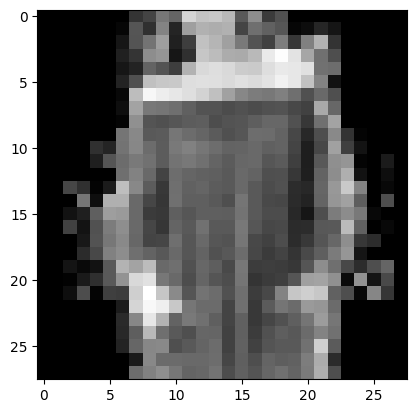

  true label: T-shirt/top, predicted label: T-shirt/top


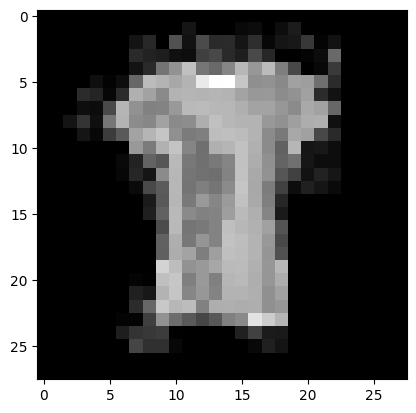

  true label: Bag, predicted label: Bag


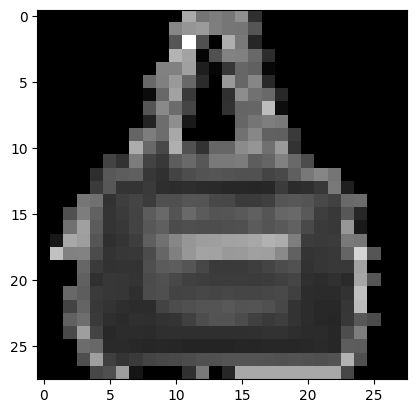

In [59]:
# correct predictions
for i in range(3):
    while True:
        img, lbl = new_dataset[np.random.randint(0, len(new_dataset))]
        pred = torch.argmax(nn.Softmax(dim=1)(cls(img.unsqueeze(0))))
        if pred == lbl:
            plt.imshow(img[0], cmap='gray')
            print(f'  true label: {label_names[lbl]}, predicted label: {label_names[pred]}')
            plt.show()
            break